In [6]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [7]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [8]:
len(words)


32033

In [9]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [10]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [12]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP
g = torch. Generator ().manual_seed (2147483647) # for reproducibility
C = torch. randn((vocab_size, n_embd), generator=g)
W1 = torch. randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch. randn(n_hidden, generator=g)
W2 = torch. randn((n_hidden, vocab_size),generator=g)
b2 = torch. randn(vocab_size,generator=g)

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total 
for p in parameters:
    p. requires_grad = True

11897


In [13]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  emb = C[Xb] # embed the characters into vectors
  embcat = emb. view(emb. shape[0], -1) # concatenate the vectors
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  h = torch. tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
    
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad
  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item() :.4f}')
  lossi.append (loss.log10().item())
  # break


      0/ 200000: 25.5262
  10000/ 200000: 1.8599
  20000/ 200000: 2.2136
  30000/ 200000: 2.3382
  40000/ 200000: 2.6947
  50000/ 200000: 2.0401
  60000/ 200000: 2.7308
  70000/ 200000: 2.5079
  80000/ 200000: 1.9719
  90000/ 200000: 2.5186
 100000/ 200000: 2.2839
 110000/ 200000: 2.1164
 120000/ 200000: 1.9916
 130000/ 200000: 1.8021
 140000/ 200000: 2.5629
 150000/ 200000: 2.2587
 160000/ 200000: 2.0283
 170000/ 200000: 2.0911
 180000/ 200000: 2.6689
 190000/ 200000: 1.8301


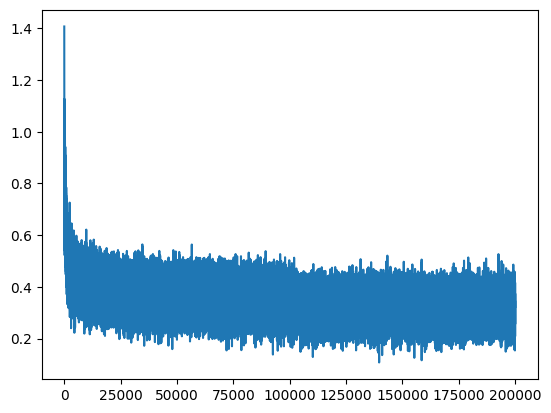

In [14]:
plt.plot(lossi)


In [16]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  h = torch.tanh(embcat @ W1 + b1)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.1252567768096924
val 2.1855852603912354


In [17]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

carmah.
amelle.
khyrilli.
taty.
skanden.
jazhutn.
den.
rhy.
kaeli.
nellara.
chaiir.
kaleigh.
ham.
joce.
quinthonoi.
wan.
adbi.
wanell.
dearynix.
kael.


In [18]:
#at initialization, we expect probablity of any character should be  1/27.0

In [19]:
-torch.tensor(1/27.0).log()

tensor(3.2958)

In [ ]:
#initially, the network is very confident that something is wrong 0/ 200000: 25.5262


In [25]:
# 4-dimensional example of the issue
logits = torch. tensor ([0.0, 0.0, 0.0, 0.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
probs, loss

(tensor([0.2500, 0.2500, 0.2500, 0.2500]), tensor(1.3863))

In [26]:
# 4-dimensional example of the issue
logits = torch. tensor ([0.0, 0.0, 5.0, 0.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
probs, loss

(tensor([0.0066, 0.0066, 0.9802, 0.0066]), tensor(0.0200))

In [27]:
# other dimension have a high logit
logits = torch. tensor ([0.0, 5.0, 0.0, 0.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
probs, loss

(tensor([0.0066, 0.9802, 0.0066, 0.0066]), tensor(5.0200))

In [29]:
# other dimension have a high logit, really high loss
logits = torch. tensor ([-3.0, 5.0, 0.0, 2.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
probs, loss

(tensor([3.1741e-04, 9.4620e-01, 6.3754e-03, 4.7108e-02]), tensor(5.0553))

In [31]:
# other dimension have a high logit, really high loss
# logits = torch. tensor ([-3.0, 5.0, 0.0, 2.0])
logits = torch.rand(4)
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
logits, probs, loss

(tensor([0.4396, 0.1486, 0.4540, 0.5697]),
 tensor([0.2564, 0.1916, 0.2601, 0.2920]),
 tensor(1.3469))

In [37]:
# other dimension have a high logit, really high loss
# logits = torch. tensor ([-3.0, 5.0, 0.0, 2.0])

#it's very unlikely you will guess the correct bucket, you are confidently wrong
logits = torch.rand(4) * 10
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
logits, probs, loss

(tensor([4.7019, 7.3419, 1.9996, 3.9651]),
 tensor([0.0643, 0.9007, 0.0043, 0.0308]),
 tensor(5.4469))

In [38]:
#so i want logits to roughly 0 when network is initialized

In [40]:
#if all one, also okay
logits = torch. tensor ([1.0, 1.0, 1.0, 1.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
probs, loss

(tensor([0.2500, 0.2500, 0.2500, 0.2500]), tensor(1.3863))

In [41]:
#if all one, also okay
logits = torch. tensor ([0.0, 0.0, 0.0, 0.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
probs, loss

(tensor([0.2500, 0.2500, 0.2500, 0.2500]), tensor(1.3863))

In [42]:
#just don's want it to be some random numbers with nrgative and positive

In [43]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP
g = torch. Generator ().manual_seed (2147483647) # for reproducibility
C = torch. randn((vocab_size, n_embd), generator=g)
W1 = torch. randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch. randn(n_hidden, generator=g)
W2 = torch. randn((n_hidden, vocab_size),generator=g)
b2 = torch. randn(vocab_size,generator=g)

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total 
for p in parameters:
    p. requires_grad = True

11897


In [44]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  emb = C[Xb] # embed the characters into vectors
  embcat = emb. view(emb. shape[0], -1) # concatenate the vectors
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  h = torch. tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
    
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad
  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item() :.4f}')
  lossi.append (loss.log10().item())
  break # break after initilization


      0/ 200000: 25.5262


In [45]:
logits[0]

tensor([  0.1576,  -2.3268,  -9.4740,  -6.7461,  13.7372, -10.4907,  -5.7905,
         10.7337,  14.0784,   4.3245,   1.9208, -14.9805,  14.0306, -10.9357,
          6.7341,   8.2830, -10.7424,  -4.5829, -14.5833, -16.0124,   7.2890,
         21.8017,  -3.0413, -20.3502,   5.5049, -13.1843,  -6.8645],
       grad_fn=<SelectBackward0>)

In [46]:
#how we make sure logits more closer to zero when initialization

In [50]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP
g = torch. Generator ().manual_seed (2147483647) # for reproducibility
C = torch. randn((vocab_size, n_embd), generator=g)
W1 = torch. randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch. randn(n_hidden, generator=g)
W2 = torch. randn((n_hidden, vocab_size),generator=g) * 0.1 #scale down w2 by 0.1
#W2 should be small numbers but should not be zero
b2 = torch. randn(vocab_size,generator=g) * 0 # set b2 to zero to avoid any random numbers for logits

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total 
for p in parameters:
    p. requires_grad = True

11897


In [49]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  emb = C[Xb] # embed the characters into vectors
  embcat = emb. view(emb. shape[0], -1) # concatenate the vectors
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  h = torch. tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
    
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad
  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item() :.4f}')
  lossi.append (loss.log10().item())
  break # break after initilization


      0/ 200000: 3.9789


In [52]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP
g = torch. Generator ().manual_seed (2147483647) # for reproducibility
C = torch. randn((vocab_size, n_embd), generator=g)
W1 = torch. randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch. randn(n_hidden, generator=g)
W2 = torch. randn((n_hidden, vocab_size),generator=g) * 0.01 #scale down w2 by 0.1
#W2 should be small numbers but should not be zero
b2 = torch. randn(vocab_size,generator=g) * 0 # set b2 to zero to avoid any random numbers for logits

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total 
for p in parameters:
    p. requires_grad = True

11897


In [53]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  emb = C[Xb] # embed the characters into vectors
  embcat = emb. view(emb. shape[0], -1) # concatenate the vectors
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  h = torch. tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
    
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad
  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item() :.4f}')
  lossi.append (loss.log10().item())
  break # break after initilization


      0/ 200000: 3.2999


In [54]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP
g = torch. Generator ().manual_seed (2147483647) # for reproducibility
C = torch. randn((vocab_size, n_embd), generator=g)
W1 = torch. randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch. randn(n_hidden, generator=g)
W2 = torch. randn((n_hidden, vocab_size),generator=g) * 0.01 #scale down w2 by 0.1
#W2 should be small numbers but should not be zero
b2 = torch. randn(vocab_size,generator=g) * 0 # set b2 to zero to avoid any random numbers for logits

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total 
for p in parameters:
    p. requires_grad = True

11897


In [55]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  emb = C[Xb] # embed the characters into vectors
  embcat = emb. view(emb. shape[0], -1) # concatenate the vectors
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  h = torch. tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
    
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad
  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item() :.4f}')
  lossi.append (loss.log10().item())


      0/ 200000: 3.2999
  10000/ 200000: 1.7637
  20000/ 200000: 2.0670
  30000/ 200000: 2.2983
  40000/ 200000: 2.5069
  50000/ 200000: 1.9090
  60000/ 200000: 2.5140
  70000/ 200000: 2.1410
  80000/ 200000: 1.8219
  90000/ 200000: 2.1900
 100000/ 200000: 2.1304
 110000/ 200000: 2.0749
 120000/ 200000: 1.9313
 130000/ 200000: 1.7900
 140000/ 200000: 2.2766
 150000/ 200000: 2.1513
 160000/ 200000: 1.8179
 170000/ 200000: 2.0655
 180000/ 200000: 2.4314
 190000/ 200000: 1.7584


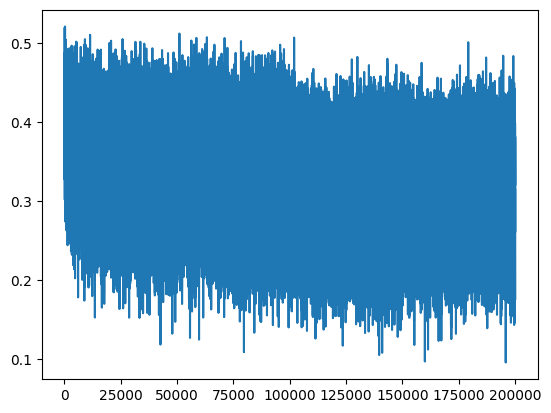

In [56]:
plt.plot(lossi)


In [59]:
#the result has been improved
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  h = torch.tanh(embcat @ W1 + b1)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0663647651672363
val 2.149362802505493


In [60]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP
g = torch. Generator ().manual_seed (2147483647) # for reproducibility
C = torch. randn((vocab_size, n_embd), generator=g)
W1 = torch. randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch. randn(n_hidden, generator=g)
W2 = torch. randn((n_hidden, vocab_size),generator=g) * 0.01 #scale down w2 by 0.1
#W2 should be small numbers but should not be zero
b2 = torch. randn(vocab_size,generator=g) * 0 # set b2 to zero to avoid any random numbers for logits

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total 
for p in parameters:
    p. requires_grad = True

11897


In [61]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  emb = C[Xb] # embed the characters into vectors
  embcat = emb. view(emb. shape[0], -1) # concatenate the vectors
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  h = torch. tanh(hpreact) # hidden layer. tanh taks arbitrary number squash them into -1 and 1
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
    
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad
  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item() :.4f}')
  lossi.append (loss.log10().item())
  break


      0/ 200000: 3.2999


In [62]:
h

tensor([[-0.9620, -1.0000, -1.0000,  ..., -0.1601, -1.0000, -1.0000],
        [ 0.1131,  0.2711, -1.0000,  ..., -0.9979,  0.9930,  1.0000],
        [-1.0000,  0.9604, -0.1418,  ..., -0.1266,  1.0000,  1.0000],
        ...,
        [-0.1424, -0.9988, -0.7355,  ..., -1.0000,  1.0000,  1.0000],
        [-0.9610,  0.7872, -0.9890,  ..., -1.0000,  0.9994,  1.0000],
        [-0.9620, -1.0000, -1.0000,  ..., -0.1601, -1.0000, -1.0000]],
       grad_fn=<TanhBackward0>)

In [63]:
#you can see how many elements are one or negative 1

In [65]:
h.shape #32 samples an 200 activations

torch.Size([32, 200])

(array([2180.,  163.,   90.,   79.,   55.,   49.,   36.,   36.,   33.,
          30.,   40.,   33.,   25.,   26.,   17.,   19.,   26.,   29.,
          23.,   21.,   22.,   26.,   20.,   30.,   15.,   16.,   16.,
          17.,   13.,   14.,   27.,   31.,   25.,   24.,   15.,   24.,
          31.,   25.,   27.,   28.,   28.,   46.,   39.,   46.,   63.,
          66.,   71.,  110.,  181., 2294.]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ]),
 <BarContainer object of 50 artists>)

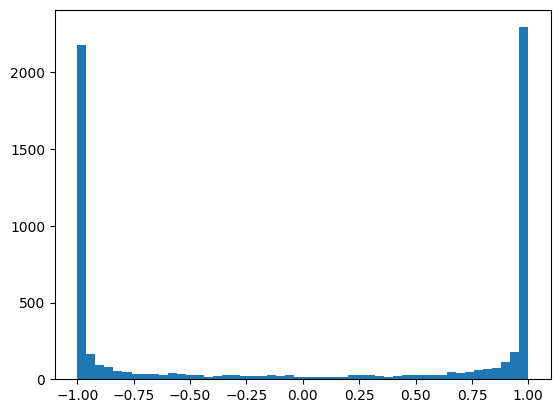

In [67]:
plt.hist(h.view(-1).tolist(), 50)

(array([  1.,   1.,   1.,   3.,  10.,  10.,  13.,  28.,  28.,  41.,  56.,
         68.,  86., 132., 170., 187., 228., 277., 294., 297., 360., 371.,
        420., 384., 419., 377., 314., 280., 282., 268., 197., 178., 132.,
        118.,  95.,  79.,  63.,  47.,  23.,  25.,   7.,   2.,   5.,   7.,
          3.,   2.,   5.,   3.,   0.,   3.]),
 array([-18.61766815, -17.8116243 , -17.00558044, -16.19953659,
        -15.39349274, -14.58744888, -13.78140503, -12.97536118,
        -12.16931732, -11.36327347, -10.55722961,  -9.75118576,
         -8.94514191,  -8.13909805,  -7.3330542 ,  -6.52701035,
         -5.72096649,  -4.91492264,  -4.10887878,  -3.30283493,
         -2.49679108,  -1.69074722,  -0.88470337,  -0.07865952,
          0.72738434,   1.53342819,   2.33947205,   3.1455159 ,
          3.95155975,   4.75760361,   5.56364746,   6.36969131,
          7.17573517,   7.98177902,   8.78782288,   9.59386673,
         10.39991058,  11.20595444,  12.01199829,  12.81804214,
         13.624086

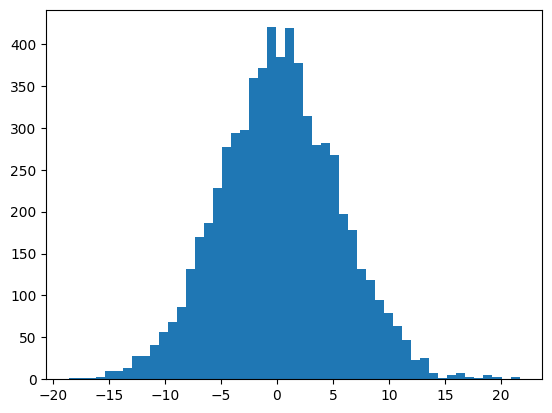

In [68]:
plt.hist(hpreact.view(-1).tolist(), 50)

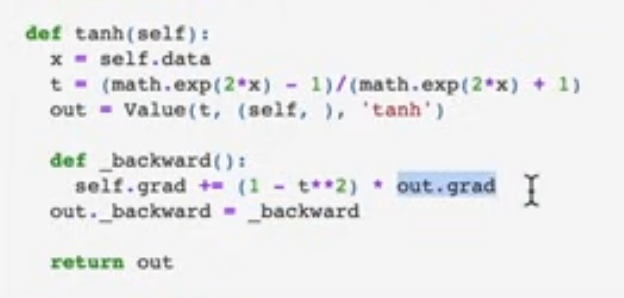

In [ ]:
#if t is 1, then back propragation will kill the gradient

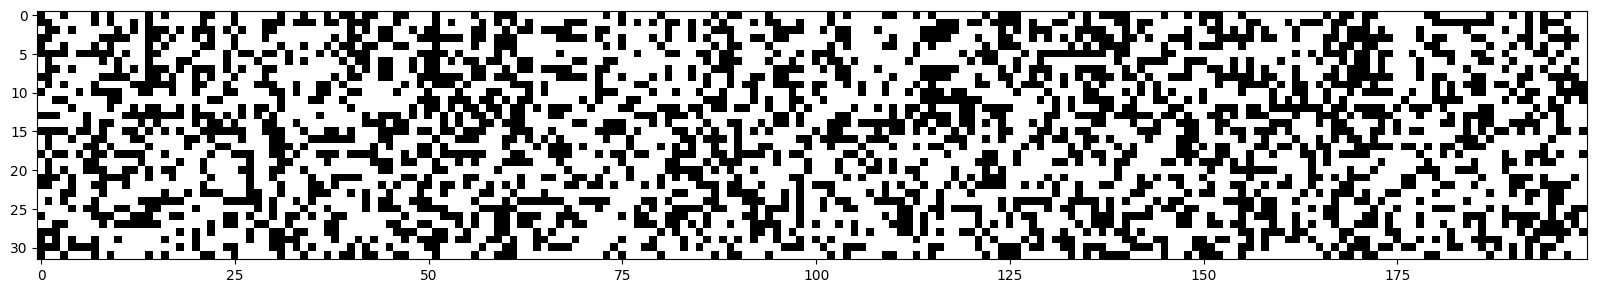

In [74]:
plt.figure(figsize=(20,10))
plt. imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

In [75]:
#a lot of them are white and they are in flat tail

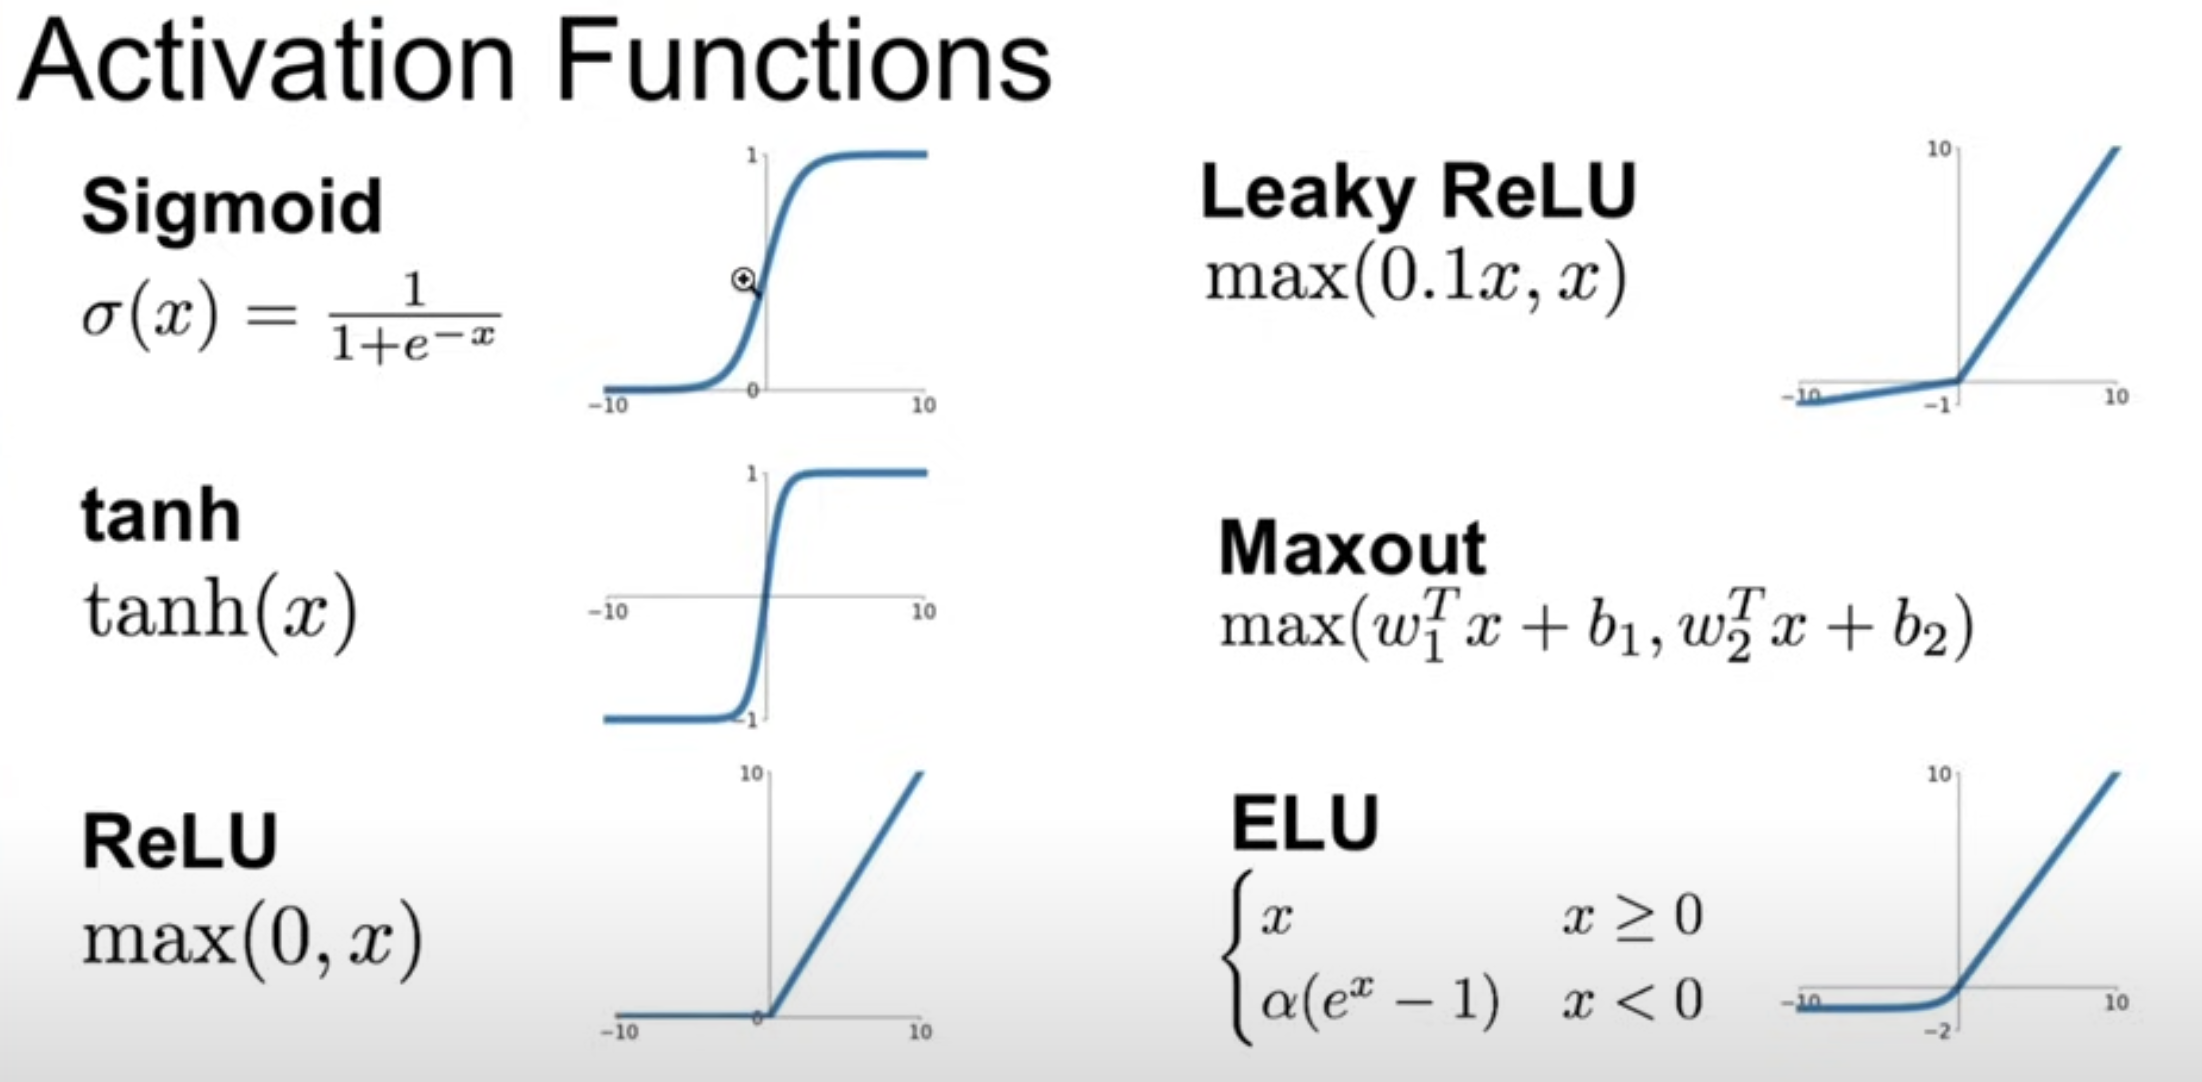

In [76]:
#some neurons will just ever dead without activation

In [77]:
#we want hpreact to close to zero

In [80]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP
g = torch. Generator ().manual_seed (2147483647) # for reproducibility
C = torch. randn((vocab_size, n_embd), generator=g)
W1 = torch. randn((n_embd * block_size, n_hidden), generator=g) * 0.1
b1 = torch. randn(n_hidden, generator=g) * 0.01
W2 = torch. randn((n_hidden, vocab_size),generator=g) * 0.01 #scale down w2 by 0.1
#W2 should be small numbers but should not be zero
b2 = torch. randn(vocab_size,generator=g) * 0 # set b2 to zero to avoid any random numbers for logits

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total 
for p in parameters:
    p. requires_grad = True

11897


In [81]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  emb = C[Xb] # embed the characters into vectors
  embcat = emb. view(emb. shape[0], -1) # concatenate the vectors
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  h = torch. tanh(hpreact) # hidden layer. tanh taks arbitrary number squash them into -1 and 1
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
    
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad
  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item() :.4f}')
  lossi.append (loss.log10().item())
  break


      0/ 200000: 3.2954


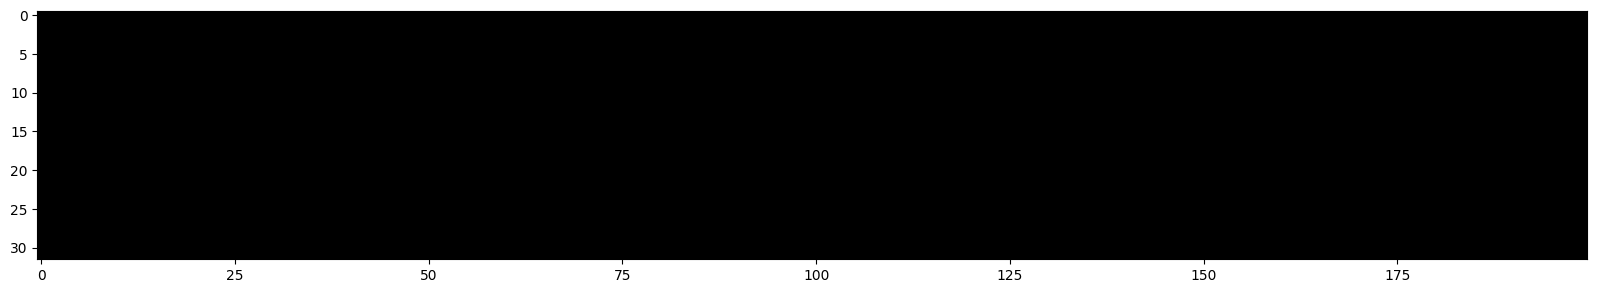

In [83]:
plt.figure(figsize=(20,10))
plt. imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

(array([  4.,  15.,  28.,  54.,  58.,  57.,  85.,  95., 105., 113., 133.,
        114., 185., 170., 172., 170., 149., 146., 183., 179., 167., 194.,
        210., 215., 196., 187., 204., 197., 198., 169., 185., 180., 126.,
        169., 177., 160., 167., 147., 144., 118., 121.,  93., 110.,  75.,
         98.,  69.,  66.,  17.,  11.,  15.]),
 array([-0.95186174, -0.91338216, -0.87490258, -0.836423  , -0.79794342,
        -0.75946383, -0.72098425, -0.68250467, -0.64402509, -0.60554551,
        -0.56706593, -0.52858635, -0.49010677, -0.45162719, -0.41314761,
        -0.37466803, -0.33618845, -0.29770886, -0.25922928, -0.2207497 ,
        -0.18227012, -0.14379054, -0.10531096, -0.06683138, -0.0283518 ,
         0.01012778,  0.04860736,  0.08708694,  0.12556653,  0.16404611,
         0.20252569,  0.24100527,  0.27948485,  0.31796443,  0.35644401,
         0.39492359,  0.43340317,  0.47188275,  0.51036233,  0.54884192,
         0.5873215 ,  0.62580108,  0.66428066,  0.70276024,  0.74123982,
 

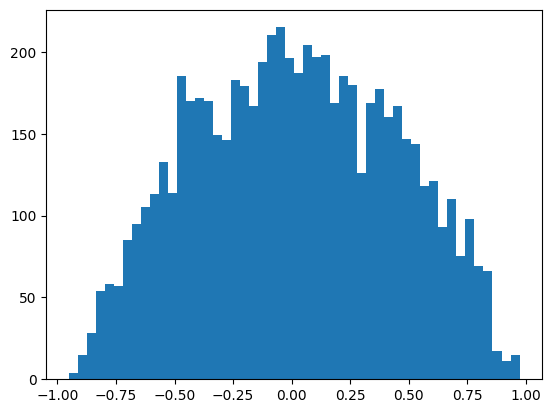

In [82]:
plt.hist(h.view(-1).tolist(), 50)

(array([  1.,   1.,   1.,   5.,   6.,   4.,   8.,  21.,  28.,  49.,  48.,
         56.,  94., 116., 150., 186., 233., 283., 310., 287., 346., 383.,
        422., 413., 397., 360., 339., 287., 297., 269., 207., 166., 127.,
        122.,  90.,  84.,  67.,  45.,  42.,  16.,   7.,   3.,   6.,   0.,
          7.,   2.,   3.,   3.,   0.,   3.]),
 array([-1.8512305 , -1.77161732, -1.69200415, -1.61239097, -1.53277779,
        -1.45316461, -1.37355144, -1.29393826, -1.21432508, -1.1347119 ,
        -1.05509872, -0.97548555, -0.89587237, -0.81625919, -0.73664601,
        -0.65703284, -0.57741966, -0.49780648, -0.4181933 , -0.33858012,
        -0.25896695, -0.17935377, -0.09974059, -0.02012741,  0.05948576,
         0.13909894,  0.21871212,  0.2983253 ,  0.37793848,  0.45755165,
         0.53716483,  0.61677801,  0.69639119,  0.77600436,  0.85561754,
         0.93523072,  1.0148439 ,  1.09445708,  1.17407025,  1.25368343,
         1.33329661,  1.41290979,  1.49252296,  1.57213614,  1.65174932,
 

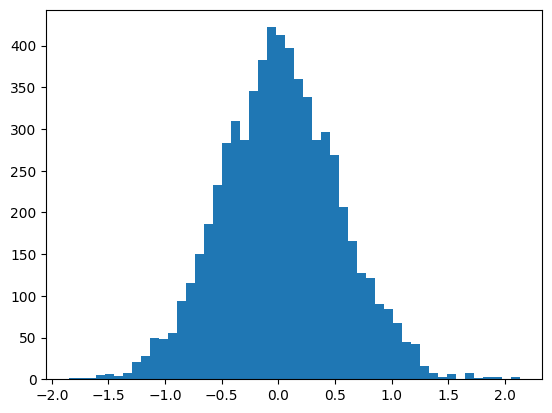

In [84]:
plt.hist(hpreact.view(-1).tolist(), 50)

In [92]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP
g = torch. Generator ().manual_seed (2147483647) # for reproducibility
C = torch. randn((vocab_size, n_embd), generator=g)
W1 = torch. randn((n_embd * block_size, n_hidden), generator=g) * 0.2
b1 = torch. randn(n_hidden, generator=g) * 0.01
W2 = torch. randn((n_hidden, vocab_size),generator=g) * 0.01 #scale down w2 by 0.1
#W2 should be small numbers but should not be zero
b2 = torch. randn(vocab_size,generator=g) * 0 # set b2 to zero to avoid any random numbers for logits

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total 
for p in parameters:
    p. requires_grad = True

11897


In [88]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  emb = C[Xb] # embed the characters into vectors
  embcat = emb. view(emb. shape[0], -1) # concatenate the vectors
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  h = torch. tanh(hpreact) # hidden layer. tanh taks arbitrary number squash them into -1 and 1
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
    
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad
  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item() :.4f}')
  lossi.append (loss.log10().item())
  break


      0/ 200000: 3.2960


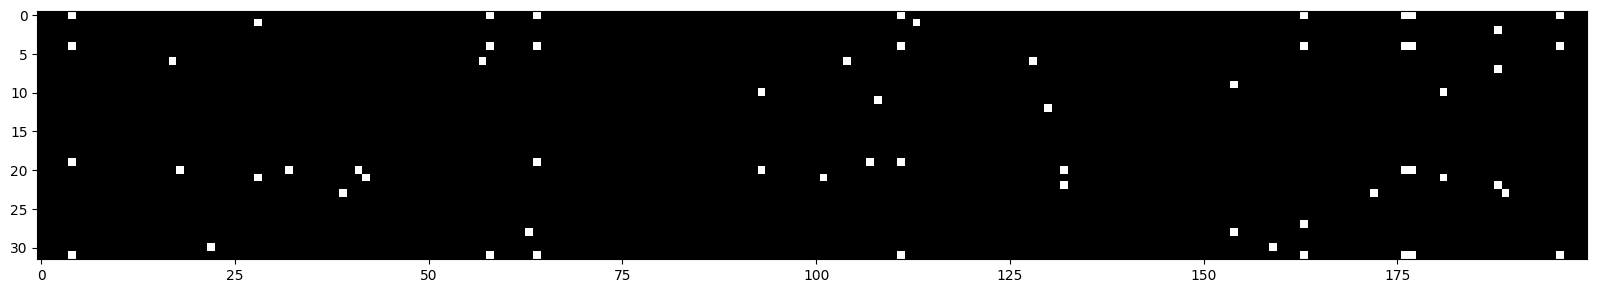

In [89]:
plt.figure(figsize=(20,10))
plt. imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

(array([180., 181., 166., 168., 137., 167., 172., 138., 139., 126.,  96.,
        103., 105., 103., 126.,  86., 105.,  96., 113., 103., 116., 102.,
         99., 118.,  98., 103.,  92., 117., 106.,  94., 116.,  99., 118.,
         95.,  97., 118., 100., 116.,  89., 108., 126., 147., 142., 155.,
        147., 169., 160., 174., 216., 253.]),
 array([-9.98781383e-01, -9.58813819e-01, -9.18846254e-01, -8.78878690e-01,
        -8.38911126e-01, -7.98943561e-01, -7.58975997e-01, -7.19008433e-01,
        -6.79040868e-01, -6.39073304e-01, -5.99105740e-01, -5.59138175e-01,
        -5.19170611e-01, -4.79203047e-01, -4.39235482e-01, -3.99267918e-01,
        -3.59300354e-01, -3.19332789e-01, -2.79365225e-01, -2.39397660e-01,
        -1.99430096e-01, -1.59462532e-01, -1.19494967e-01, -7.95274031e-02,
        -3.95598388e-02,  4.07725573e-04,  4.03752899e-02,  8.03428543e-02,
         1.20310419e-01,  1.60277983e-01,  2.00245547e-01,  2.40213112e-01,
         2.80180676e-01,  3.20148240e-01,  3.60115

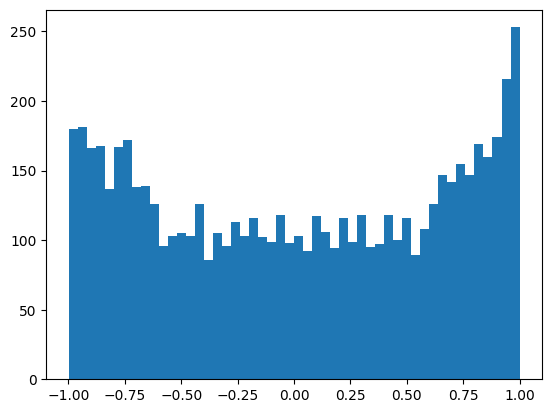

In [90]:
plt.hist(h.view(-1).tolist(), 50)

(array([  1.,   1.,   1.,   5.,   6.,   4.,   8.,  18.,  33.,  46.,  49.,
         56.,  95., 117., 148., 182., 221., 300., 309., 290., 340., 386.,
        419., 410., 395., 367., 338., 283., 302., 265., 209., 171., 121.,
        121.,  94.,  83.,  65.,  50.,  39.,  19.,   6.,   4.,   5.,   0.,
          7.,   1.,   4.,   3.,   0.,   3.]),
 array([-3.70129013, -3.54217392, -3.38305771, -3.2239415 , -3.06482529,
        -2.90570908, -2.74659286, -2.58747665, -2.42836044, -2.26924423,
        -2.11012802, -1.95101181, -1.7918956 , -1.63277939, -1.47366318,
        -1.31454697, -1.15543076, -0.99631454, -0.83719833, -0.67808212,
        -0.51896591, -0.3598497 , -0.20073349, -0.04161728,  0.11749893,
         0.27661514,  0.43573135,  0.59484756,  0.75396378,  0.91307999,
         1.0721962 ,  1.23131241,  1.39042862,  1.54954483,  1.70866104,
         1.86777725,  2.02689346,  2.18600967,  2.34512589,  2.5042421 ,
         2.66335831,  2.82247452,  2.98159073,  3.14070694,  3.29982315,
 

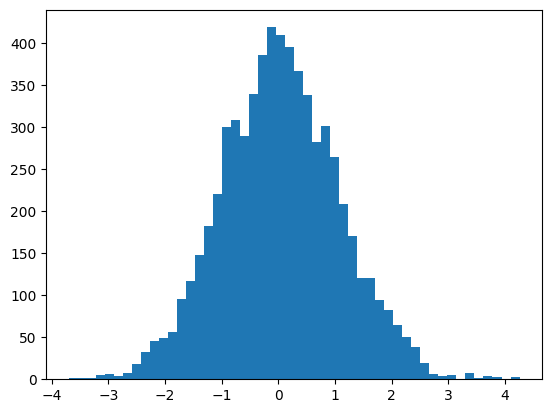

In [91]:
plt.hist(hpreact.view(-1).tolist(), 50)

In [ ]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP
g = torch. Generator ().manual_seed (2147483647) # for reproducibility
C = torch. randn((vocab_size, n_embd), generator=g)
W1 = torch. randn((n_embd * block_size, n_hidden), generator=g) * 0.2
b1 = torch. randn(n_hidden, generator=g) * 0.01
W2 = torch. randn((n_hidden, vocab_size),generator=g) * 0.01 #scale down w2 by 0.1
#W2 should be small numbers but should not be zero
b2 = torch. randn(vocab_size,generator=g) * 0 # set b2 to zero to avoid any random numbers for logits

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total 
for p in parameters:
    p. requires_grad = True

In [93]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  emb = C[Xb] # embed the characters into vectors
  embcat = emb. view(emb. shape[0], -1) # concatenate the vectors
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  h = torch. tanh(hpreact) # hidden layer. tanh taks arbitrary number squash them into -1 and 1
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
    
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad
  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item() :.4f}')
  lossi.append (loss.log10().item())



      0/ 200000: 3.2960
  10000/ 200000: 1.7230
  20000/ 200000: 1.8993
  30000/ 200000: 2.3189
  40000/ 200000: 2.3966
  50000/ 200000: 1.7525
  60000/ 200000: 2.4758
  70000/ 200000: 2.0606
  80000/ 200000: 1.6298
  90000/ 200000: 2.2016
 100000/ 200000: 2.1672
 110000/ 200000: 2.0842
 120000/ 200000: 1.8484
 130000/ 200000: 1.7762
 140000/ 200000: 2.2086
 150000/ 200000: 2.1344
 160000/ 200000: 1.8533
 170000/ 200000: 2.0589
 180000/ 200000: 2.5654
 190000/ 200000: 1.7173


In [94]:
#the result has been improved
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  h = torch.tanh(embcat @ W1 + b1)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0355141162872314
val 2.118774175643921


In [96]:
#this network is so shallow, so the optimization problem is so easy
#The deeper your network has, it's not more forgiving 

tensor(-0.0120) tensor(1.0013)
tensor(0.0002) tensor(3.1933)


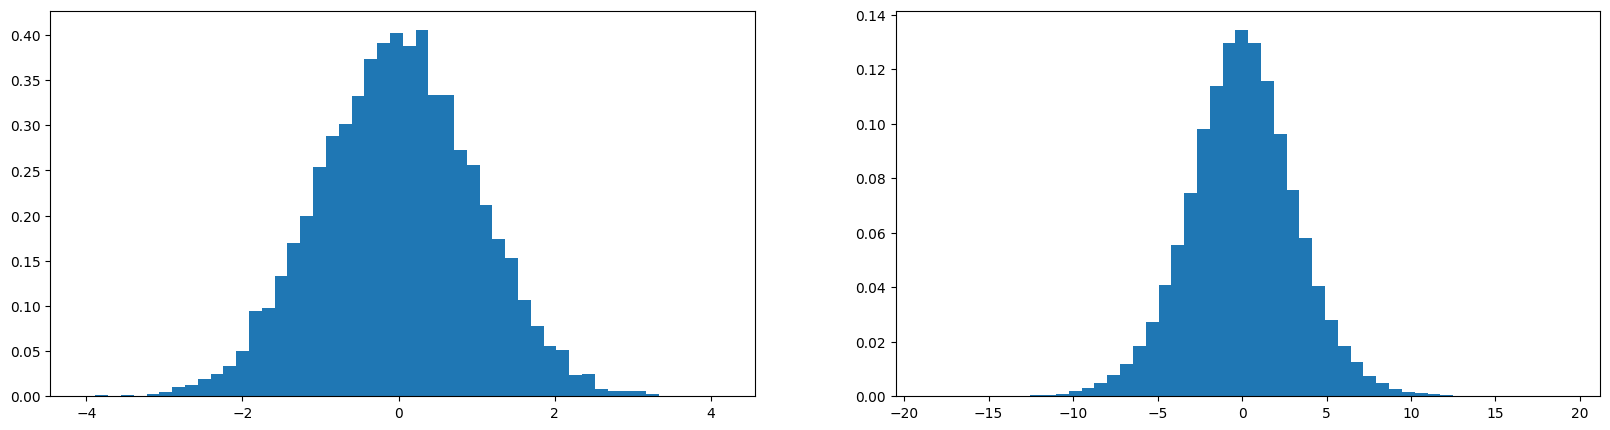

In [104]:
#we have random input from x, that is from gausin. Which has 1000 examples and 10 dimensional 
#we have a weight layer here, which is also using gausin,neuron at hidden layer looks at 10 inputs and 200 neurons at the hidden layer
x = torch. randn (1000, 10)

w = torch. randn(10, 200)

#get the pre-activation here
y =x @ w

#originally, x's mean is zero, and standard deviation is 1
#the mean of y is almost the same, about zero, but the standard deviation has been expanded into 3
#we want the network to have the similar activations
print (x.mean(), x.std())
print (y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot (121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt. subplot (122)
plt.hist(y.view(-1).tolist(), 50, density=True);

In [ ]:
#if i scale w

tensor(0.0067) tensor(1.0046)
tensor(-0.0107) tensor(15.5523)


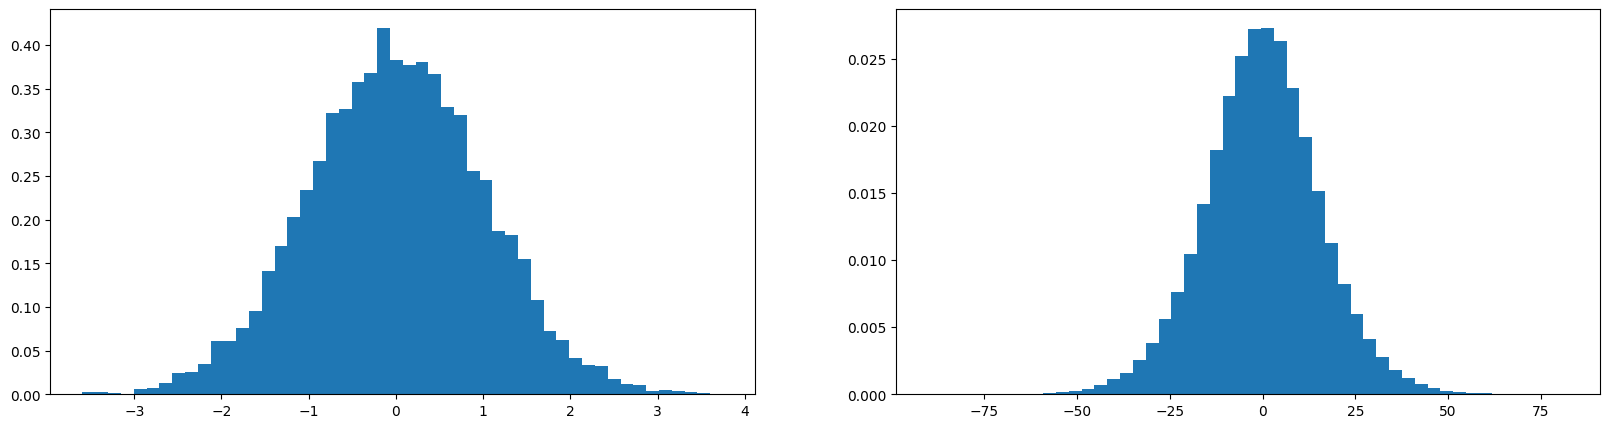

In [106]:
#we have random input from x, that is from gausin. Which has 1000 examples and 10 dimensional 
#we have a weight layer here, which is also using gausin,neuron at hidden layer looks at 10 inputs and 200 neurons at the hidden layer
x = torch. randn (1000, 10)

w = torch. randn(10, 200) * 5

#get the pre-activation here
y =x @ w

#originally, x's mean is zero, and standard deviation is 1
#the mean of y is almost the same, about zero, but the standard deviation has been expanded into 3
#we want the network to have the similar activations
print (x.mean(), x.std())
print (y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot (121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt. subplot (122)
plt.hist(y.view(-1).tolist(), 50, density=True);

In [107]:
#if we scale it down, the gausin got smaller 

tensor(-0.0070) tensor(1.0004)
tensor(0.0010) tensor(0.6473)


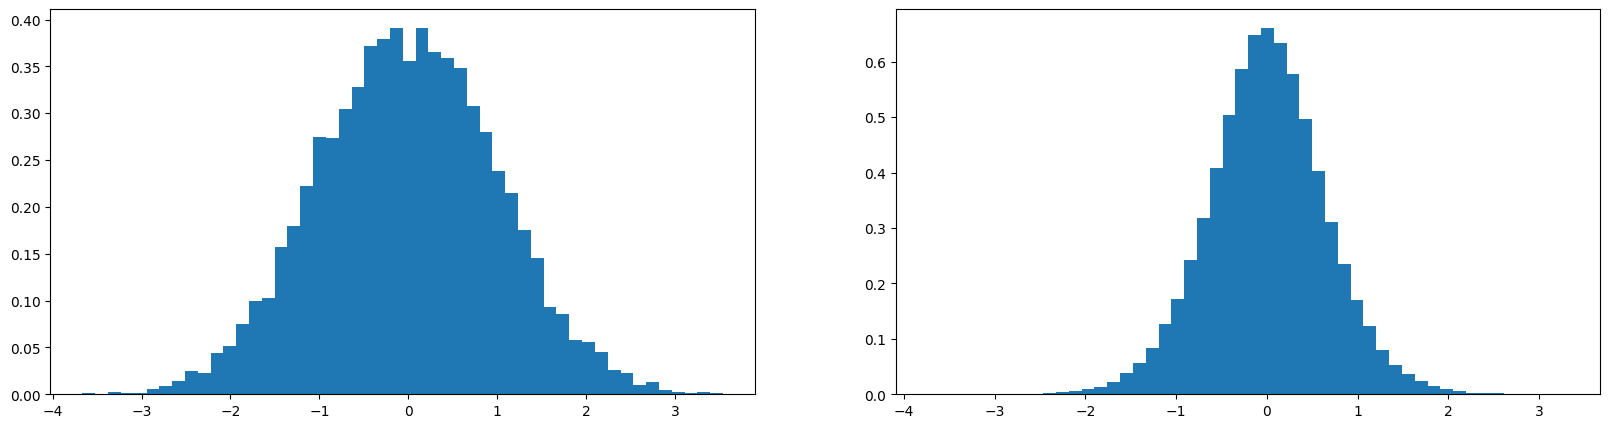

In [111]:
#we have random input from x, that is from gausin. Which has 1000 examples and 10 dimensional 
#we have a weight layer here, which is also using gausin,neuron at hidden layer looks at 10 inputs and 200 neurons at the hidden layer
x = torch. randn (1000, 10)

w = torch. randn(10, 200) * 0.2

#get the pre-activation here
y =x @ w

#originally, x's mean is zero, and standard deviation is 1
#the mean of y is almost the same, about zero, but the standard deviation has been expanded into 3
#we want the network to have the similar activations
print (x.mean(), x.std())
print (y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot (121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt. subplot (122)
plt.hist(y.view(-1).tolist(), 50, density=True);

In [109]:
#we should divide the input's 10's square root

tensor(-0.0011) tensor(0.9864)
tensor(0.0012) tensor(0.9706)


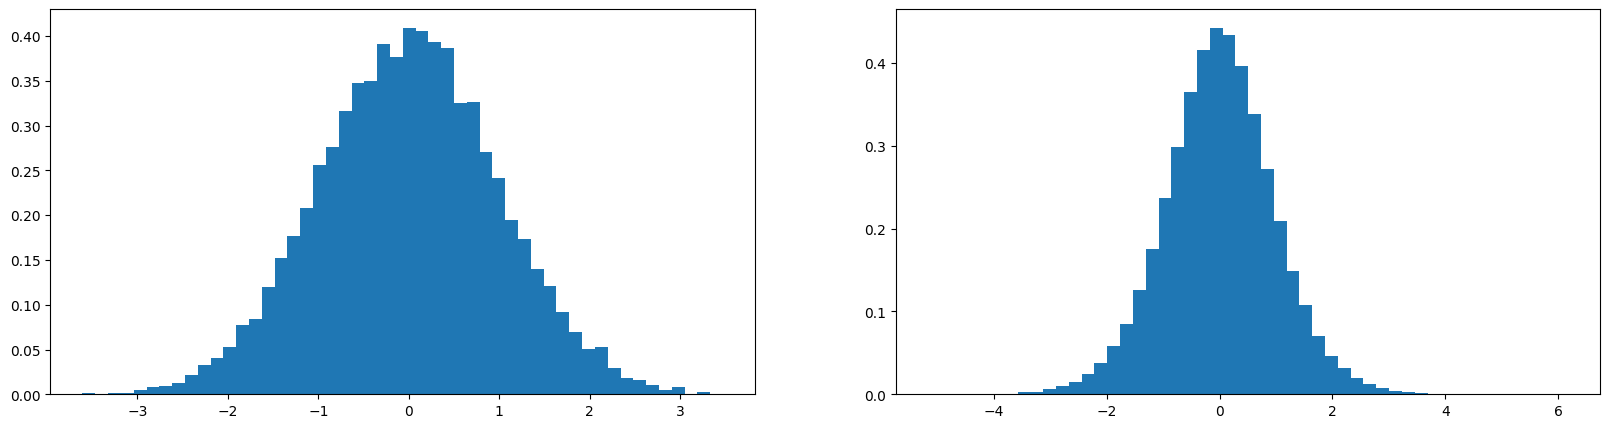

In [112]:
#we have random input from x, that is from gausin. Which has 1000 examples and 10 dimensional 
#we have a weight layer here, which is also using gausin,neuron at hidden layer looks at 10 inputs and 200 neurons at the hidden layer
x = torch. randn (1000, 10)

w = torch. randn(10, 200) / 10 ** 0.5

#get the pre-activation here
y =x @ w

#originally, x's mean is zero, and standard deviation is 1
#the mean of y is almost the same, about zero, but the standard deviation has been expanded into 3
#we want the network to have the similar activations
print (x.mean(), x.std())
print (y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot (121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt. subplot (122)
plt.hist(y.view(-1).tolist(), 50, density=True);

In [113]:
#this is the proper way that how initialize the weight

In [115]:
#https://arxiv.org/pdf/1502.01852

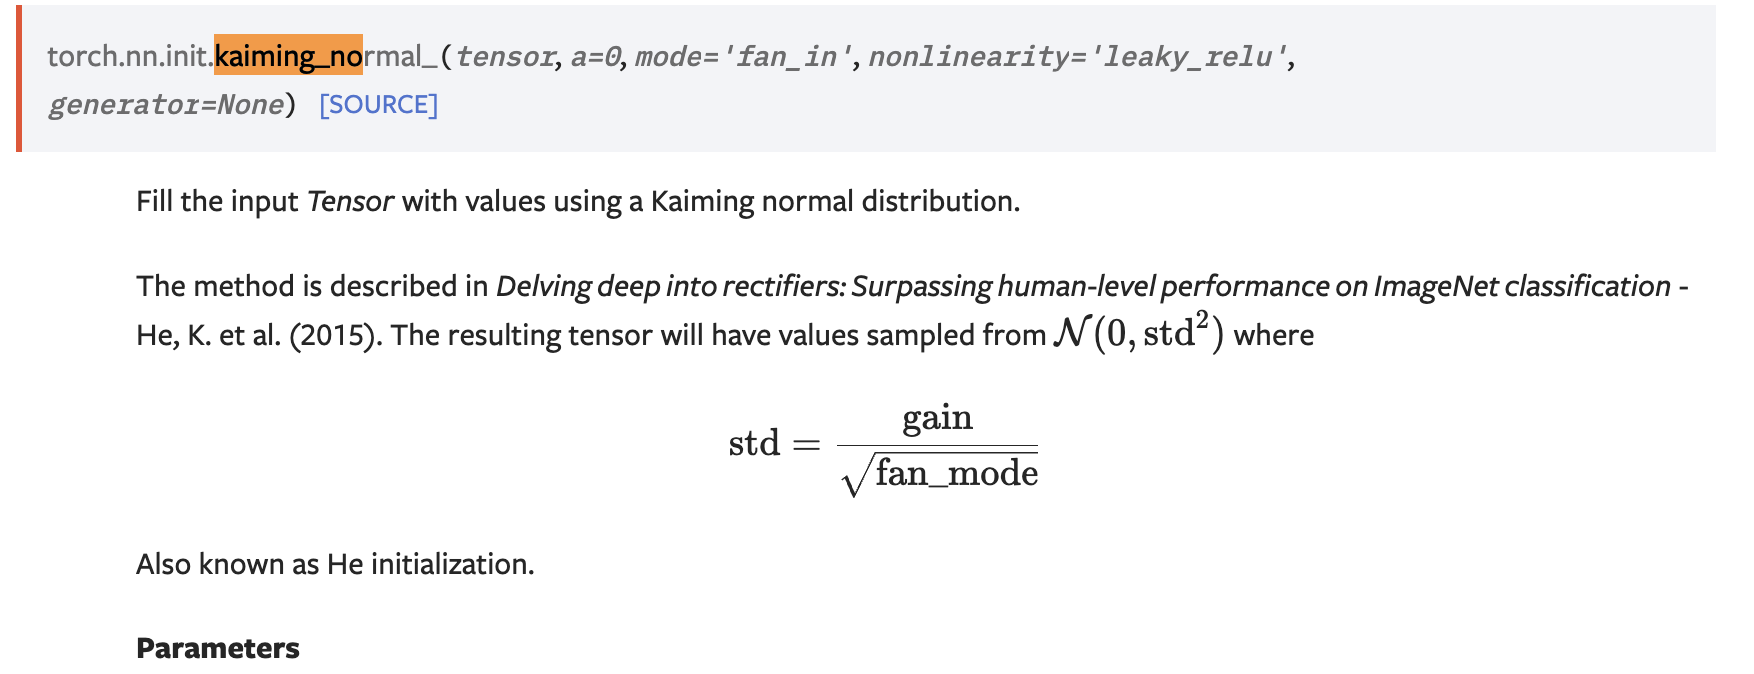


In [118]:
torch.randn(10000).std()

tensor(1.0005)

In [119]:
(torch.randn(10000)*0.2).std()

tensor(0.1991)

In [121]:
#gain for tanh is 5/3

In [ ]:
# the fan in for W1 is actually n_embd * block_size

In [123]:
(5/3) / 30 ** 0.5

0.3042903097250923

In [127]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP
g = torch. Generator ().manual_seed (2147483647) # for reproducibility
C = torch. randn((vocab_size, n_embd), generator=g)
W1 = torch. randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / ((n_embd * block_size) ** 0.5) #0.2
b1 = torch. randn(n_hidden, generator=g) * 0.01
W2 = torch. randn((n_hidden, vocab_size),generator=g) * 0.01 #scale down w2 by 0.1
#W2 should be small numbers but should not be zero
b2 = torch. randn(vocab_size,generator=g) * 0 # set b2 to zero to avoid any random numbers for logits

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total 
for p in parameters:
    p. requires_grad = True

11897


In [128]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  emb = C[Xb] # embed the characters into vectors
  embcat = emb. view(emb. shape[0], -1) # concatenate the vectors
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  h = torch. tanh(hpreact) # hidden layer. tanh taks arbitrary number squash them into -1 and 1
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
    
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad
  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item() :.4f}')
  lossi.append (loss.log10().item())



      0/ 200000: 3.2963
  10000/ 200000: 1.6929
  20000/ 200000: 1.8320
  30000/ 200000: 2.3207
  40000/ 200000: 2.4915
  50000/ 200000: 1.7569
  60000/ 200000: 2.4385
  70000/ 200000: 2.1219
  80000/ 200000: 1.6795
  90000/ 200000: 2.1480
 100000/ 200000: 2.1768
 110000/ 200000: 2.0357
 120000/ 200000: 1.7839
 130000/ 200000: 1.7549
 140000/ 200000: 2.1074
 150000/ 200000: 2.1052
 160000/ 200000: 1.7375
 170000/ 200000: 2.0859
 180000/ 200000: 2.5050
 190000/ 200000: 1.7592


In [129]:
#the result has been improved
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  h = torch.tanh(embcat @ W1 + b1)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.035102605819702
val 2.1148674488067627


In [130]:
#batch normanization 
#https://arxiv.org/pdf/1502.03167

In [131]:
#basically we have these hidden states
#we don't want these pre activation become way too small, then the tanh is not doing anything
#but we don't them too big, becasue the tanh is saturated
#i want them to be roughly guasin
#Why not just take the hidden state and normalize it as gausin
#it sounds crazy but you can just do that

In [132]:
hpreact.shape

torch.Size([32, 200])

In [134]:
hpreact.mean(0, keepdim=True).shape

torch.Size([1, 200])

In [135]:
hpreact.std(0, keepdim=True).shape

torch.Size([1, 200])

In [137]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP
g = torch. Generator ().manual_seed (2147483647) # for reproducibility
C = torch. randn((vocab_size, n_embd), generator=g)
W1 = torch. randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / ((n_embd * block_size) ** 0.5) #0.2
b1 = torch. randn(n_hidden, generator=g) * 0.01
W2 = torch. randn((n_hidden, vocab_size),generator=g) * 0.01 #scale down w2 by 0.1
#W2 should be small numbers but should not be zero
b2 = torch. randn(vocab_size,generator=g) * 0 # set b2 to zero to avoid any random numbers for logits

bngain = torch.ones ((1, n_hidden))
bbias = torch.zeros ((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total 
for p in parameters:
    p. requires_grad = True

12297


In [138]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  emb = C[Xb] # embed the characters into vectors
  embcat = emb. view(emb. shape[0], -1) # concatenate the vectors
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  h = torch. tanh(hpreact) # hidden layer. tanh taks arbitrary number squash them into -1 and 1
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
    
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad
  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item() :.4f}')
  lossi.append (loss.log10().item())



      0/ 200000: 3.3054
  10000/ 200000: 1.7978
  20000/ 200000: 1.9030
  30000/ 200000: 2.4623
  40000/ 200000: 2.4436
  50000/ 200000: 1.8843
  60000/ 200000: 2.4164
  70000/ 200000: 2.1734
  80000/ 200000: 1.7217
  90000/ 200000: 2.3225
 100000/ 200000: 2.2514
 110000/ 200000: 2.1481
 120000/ 200000: 1.9692
 130000/ 200000: 1.7992
 140000/ 200000: 2.2786
 150000/ 200000: 2.1926
 160000/ 200000: 1.9286
 170000/ 200000: 2.1592
 180000/ 200000: 2.5601
 190000/ 200000: 1.7961


In [139]:
#the result has been improved
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0649521350860596
val 2.1251983642578125


🟢 "Too small → almost no activation"
If the pre-activation input x is very close to zero, then:

tanh(x) ≈ x

Example: tanh(0.01) ≈ 0.01

📌 Meaning: It’s like a weak signal barely getting through.

The neuron is acting almost linear (no added power).

Not much transformation is happening → the network becomes less expressive.

🔴 "Too large → saturation → gradients vanish"
If x is very big or very negative:

tanh(x) ≈ 1

tanh(-x) ≈ -1

That’s saturation. The curve becomes flat.

💥 Now here’s the key part:

The gradient of tanh(x) is:
1 - tanh(x)^2

So:

When tanh(x) ≈ ±1 → gradient ≈ 0

This is called the vanishing gradient problem.

📌 Meaning:
When the input is too big, the neuron fires the same value every time (just ±1), and its gradient becomes zero, so the model stops learning.



In [143]:
#but the batch normalization adds a terrible  cost
#those batches examples are processed independently 
#Now we are copupling these samples mathematically and in the forward and backward pass
#h is going to change like a jitter
# will get a jitter for logits and h
#think of it as a regularizer
#we should not couple the examples into the batch
#the neuron expectes batch as input now, we can't test it

In [161]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP
g = torch. Generator ().manual_seed (2147483647) # for reproducibility
C = torch. randn((vocab_size, n_embd), generator=g)
W1 = torch. randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / ((n_embd * block_size) ** 0.5) #0.2
b1 = torch. randn(n_hidden, generator=g) * 0.01
W2 = torch. randn((n_hidden, vocab_size),generator=g) * 0.01 #scale down w2 by 0.1
#W2 should be small numbers but should not be zero
b2 = torch. randn(vocab_size,generator=g) * 0 # set b2 to zero to avoid any random numbers for logits

bngain = torch.ones ((1, n_hidden))
bbias = torch.zeros ((1, n_hidden))
bnmean_running = torch.zeros ((1, n_hidden))
bnstd_running = torch.zeros ((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total 
for p in parameters:
    p. requires_grad = True

12297


In [162]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  emb = C[Xb] # embed the characters into vectors
  embcat = emb. view(emb. shape[0], -1) # concatenate the vectors
  # hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  hpreact = embcat @ W1 #+ b1 #bias is not needed
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  h = torch. tanh(hpreact) # hidden layer. tanh taks arbitrary number squash them into -1 and 1
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
    
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad
  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item() :.4f}')
  lossi.append (loss.log10().item())



      0/ 200000: 3.2968
  10000/ 200000: 1.7862
  20000/ 200000: 1.8888
  30000/ 200000: 2.3784
  40000/ 200000: 2.4609
  50000/ 200000: 1.9015
  60000/ 200000: 2.3775
  70000/ 200000: 2.1530
  80000/ 200000: 1.7665
  90000/ 200000: 2.2764
 100000/ 200000: 2.2369
 110000/ 200000: 2.2475
 120000/ 200000: 1.9581
 130000/ 200000: 1.7859
 140000/ 200000: 2.2012
 150000/ 200000: 2.1106
 160000/ 200000: 1.8243
 170000/ 200000: 2.1077
 180000/ 200000: 2.5077
 190000/ 200000: 1.8710


In [163]:
# # calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 # + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)

In [164]:
bnmean

tensor([[-2.0810e+00,  3.7313e-01, -1.6936e+00,  3.1222e-01,  1.5266e+00,
          8.8137e-01,  2.2334e+00, -1.8644e+00,  4.5306e-01,  1.6263e+00,
         -1.7190e+00, -2.4594e+00, -4.7007e-01, -1.0758e+00,  4.0325e-01,
          3.3503e-01,  2.4657e-01, -2.4252e+00, -4.5118e-01,  1.5510e+00,
          5.4253e-01,  6.1285e-02,  5.6598e-01,  1.3201e+00,  1.4217e+00,
          1.1580e+00,  1.2511e+00,  5.1476e-01,  1.8447e-01,  1.9721e+00,
         -8.1699e-01, -1.2908e+00, -1.2345e+00,  3.1390e-01, -1.0457e-01,
         -1.2587e+00, -2.7979e-01, -9.7733e-02, -1.5353e+00,  2.8087e-01,
          1.1003e-01, -5.2082e-01, -1.4440e+00, -2.1395e-02,  1.4487e+00,
         -1.0751e-03,  1.2230e+00, -1.0871e+00,  8.9394e-01,  1.1106e+00,
          6.9584e-01, -1.8701e-01,  1.6953e+00,  1.7843e+00,  1.1084e+00,
         -2.2028e+00, -3.9018e-01,  3.5651e-01,  7.2192e-01, -1.4724e+00,
         -1.9897e-01,  9.9720e-01,  6.6859e-01,  3.0696e-01,  1.2021e+00,
          6.1964e-01, -5.3214e-01,  1.

In [165]:
bnmean_running

tensor([[-2.1063e+00,  3.6626e-01, -1.6924e+00,  3.4257e-01,  1.5142e+00,
          8.8032e-01,  2.2324e+00, -1.8749e+00,  4.4618e-01,  1.6444e+00,
         -1.6936e+00, -2.4750e+00, -4.6818e-01, -1.0600e+00,  4.1473e-01,
          3.4805e-01,  2.4317e-01, -2.4304e+00, -4.6202e-01,  1.5723e+00,
          5.3653e-01,  7.4071e-02,  5.6334e-01,  1.3242e+00,  1.4261e+00,
          1.1711e+00,  1.2684e+00,  5.2557e-01,  1.8359e-01,  1.9720e+00,
         -8.0094e-01, -1.2879e+00, -1.2256e+00,  3.1115e-01, -1.1553e-01,
         -1.2733e+00, -2.9012e-01, -9.5827e-02, -1.5269e+00,  2.9552e-01,
          1.1421e-01, -5.1413e-01, -1.4364e+00, -3.7732e-02,  1.4469e+00,
         -3.1787e-03,  1.2316e+00, -1.0989e+00,  8.8655e-01,  1.0951e+00,
          6.9225e-01, -1.9889e-01,  1.6803e+00,  1.7894e+00,  1.1010e+00,
         -2.2113e+00, -3.7298e-01,  3.5712e-01,  7.2788e-01, -1.4684e+00,
         -1.9105e-01,  1.0011e+00,  6.6642e-01,  3.0505e-01,  1.1957e+00,
          6.1103e-01, -5.2570e-01,  1.

In [166]:
#the result has been improved
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.062053680419922
val 2.120556592941284


In [167]:
#the result has been improved
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0619096755981445
val 2.1210341453552246


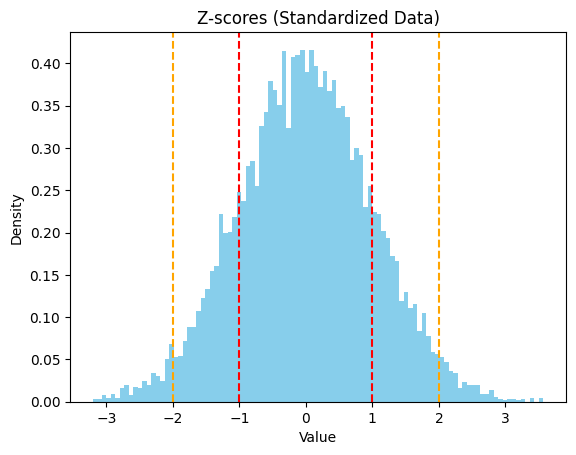

In [168]:
import numpy as np
import matplotlib.pyplot as plt

# Simulate 10,000 random values with mean=50, std=10
data = np.random.normal(loc=50, scale=10, size=10000)

# Standardize
z_scores = (data - np.mean(data)) / np.std(data)

# Plot histogram
plt.hist(z_scores, bins=100, density=True, color='skyblue')
plt.axvline(-1, color='red', linestyle='--')
plt.axvline(1, color='red', linestyle='--')
plt.axvline(-2, color='orange', linestyle='--')
plt.axvline(2, color='orange', linestyle='--')
plt.title("Z-scores (Standardized Data)")
plt.xlabel("Value")
plt.ylabel("Density")
plt.show()


In [169]:
#https://github.com/GeJulia/NIFF/blob/main/resnet_niff_full.py

In [ ]:
# SUMMARY + PYTORCHIFYING -----------


In [76]:
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch

class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
# layers = [
#   Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
# ]

layers = [
  Linear(n_embd * block_size, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size),
]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3
      #gain in necessary to fight the squashing

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

46497


In [77]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  # break
  if i >= 1000:
    break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.2962


layer 1 (      Tanh): mean -0.04, std 0.76, saturated: 21.97%
layer 3 (      Tanh): mean -0.01, std 0.72, saturated: 11.00%
layer 5 (      Tanh): mean +0.01, std 0.73, saturated: 13.00%
layer 7 (      Tanh): mean -0.05, std 0.73, saturated: 13.34%
layer 9 (      Tanh): mean +0.00, std 0.72, saturated: 10.53%


Text(0.5, 1.0, 'activation distribution')

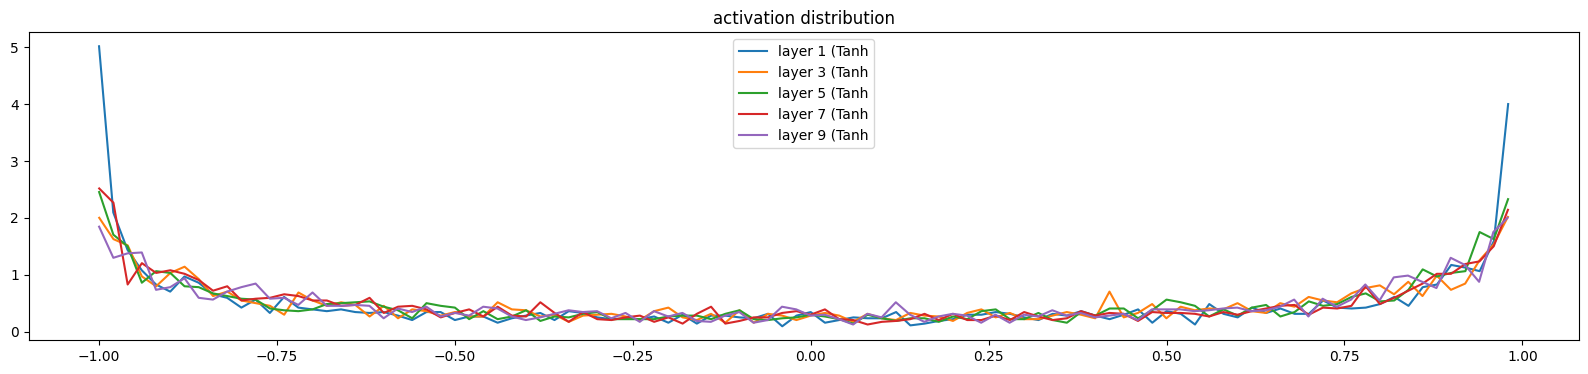

In [78]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 1 (      Tanh): mean +0.000024, std 3.353991e-03
layer 3 (      Tanh): mean +0.000012, std 3.157343e-03
layer 5 (      Tanh): mean -0.000004, std 2.925863e-03
layer 7 (      Tanh): mean +0.000036, std 2.715700e-03
layer 9 (      Tanh): mean +0.000020, std 2.308167e-03


Text(0.5, 1.0, 'gradient distribution')

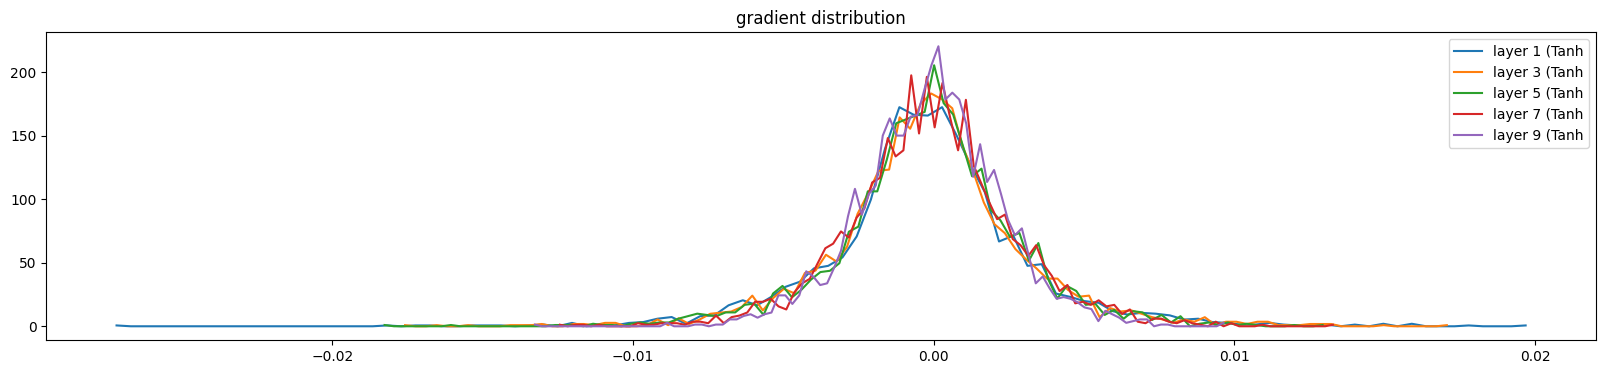

In [79]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000980 | std 1.189170e-02 | grad:data ratio 1.189149e-02
weight  (30, 100) | mean +0.000118 | std 1.005290e-02 | grad:data ratio 3.214555e-02
weight (100, 100) | mean +0.000033 | std 7.821211e-03 | grad:data ratio 4.653361e-02
weight (100, 100) | mean -0.000107 | std 6.655620e-03 | grad:data ratio 3.925851e-02
weight (100, 100) | mean -0.000017 | std 6.086040e-03 | grad:data ratio 3.605767e-02
weight (100, 100) | mean -0.000077 | std 5.075620e-03 | grad:data ratio 3.015269e-02
weight  (100, 27) | mean -0.000000 | std 2.056585e-02 | grad:data ratio 2.909911e-01


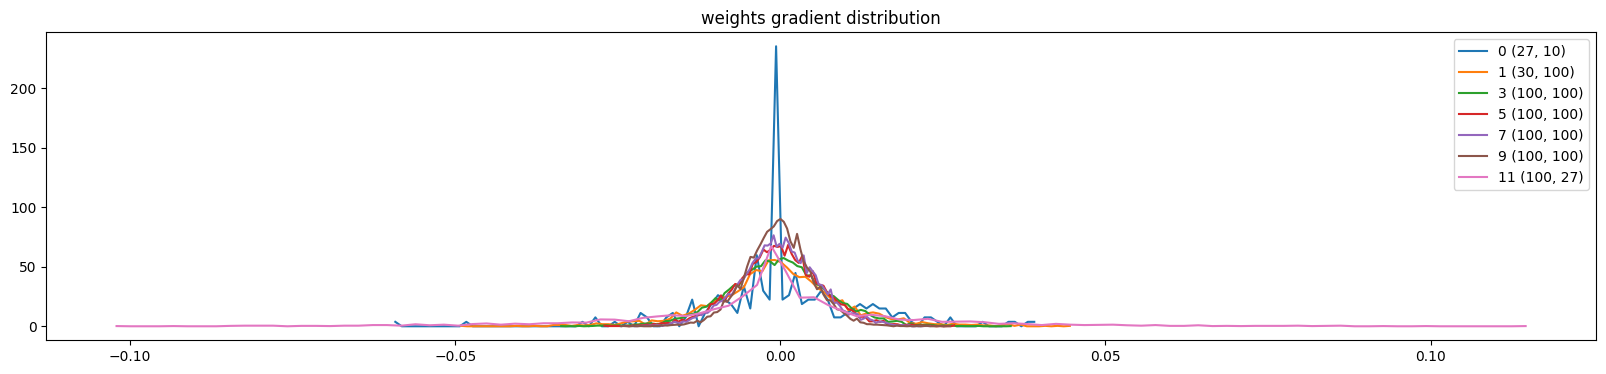

In [80]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

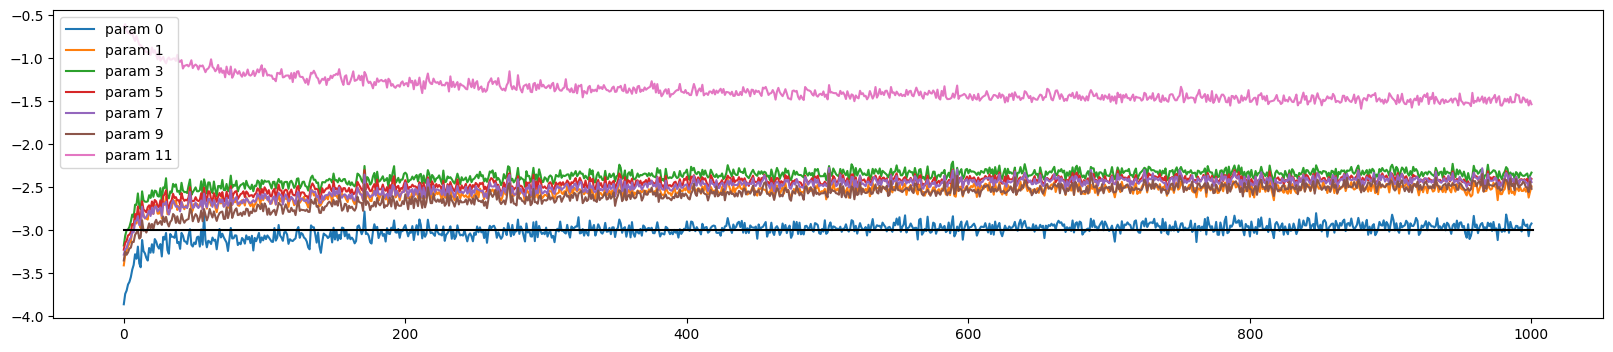

In [81]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [91]:
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch

class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) #/ fan_in **0.5
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]
# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  #layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1.0 #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

47024


In [92]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.2870


layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.62%
layer 5 (      Tanh): mean +0.00, std 0.63, saturated: 2.59%
layer 8 (      Tanh): mean -0.00, std 0.64, saturated: 2.34%
layer 11 (      Tanh): mean -0.00, std 0.64, saturated: 2.62%
layer 14 (      Tanh): mean +0.00, std 0.64, saturated: 2.50%


Text(0.5, 1.0, 'activation distribution')

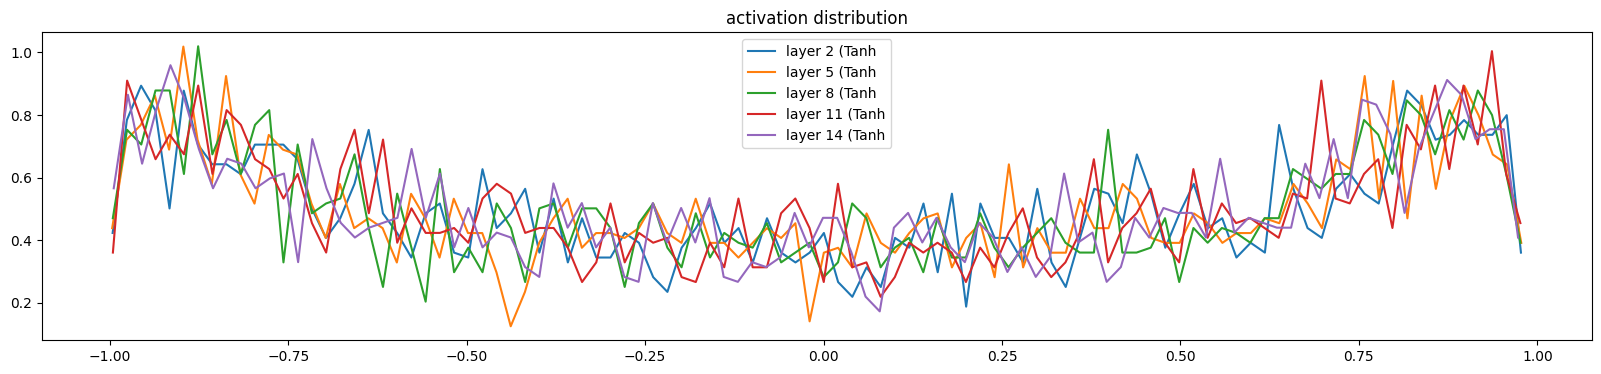

In [93]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')


layer 2 (      Tanh): mean -0.000000, std 3.093912e-03
layer 5 (      Tanh): mean +0.000000, std 2.661322e-03
layer 8 (      Tanh): mean +0.000000, std 2.426213e-03
layer 11 (      Tanh): mean -0.000000, std 2.269459e-03
layer 14 (      Tanh): mean +0.000000, std 1.983031e-03


Text(0.5, 1.0, 'gradient distribution')

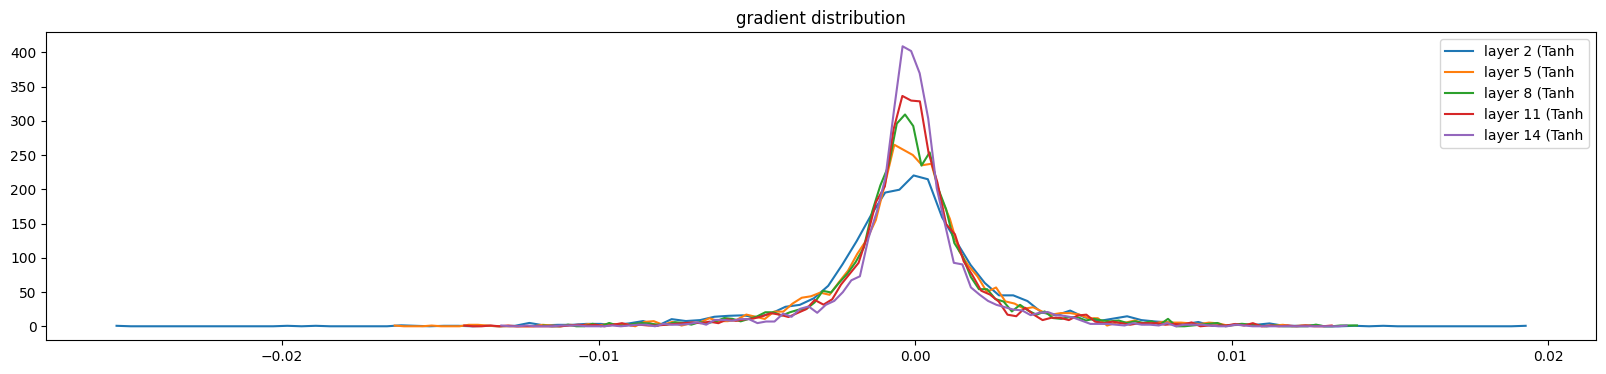

In [94]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000000 | std 6.705950e-03 | grad:data ratio 6.700181e-03
weight  (30, 100) | mean -0.000003 | std 2.026518e-03 | grad:data ratio 1.977298e-03
weight (100, 100) | mean +0.000013 | std 1.104427e-03 | grad:data ratio 1.108056e-03
weight (100, 100) | mean +0.000005 | std 9.566543e-04 | grad:data ratio 9.497147e-04
weight (100, 100) | mean +0.000003 | std 8.406345e-04 | grad:data ratio 8.380437e-04
weight (100, 100) | mean +0.000001 | std 7.872587e-04 | grad:data ratio 7.840730e-04
weight  (100, 27) | mean -0.000002 | std 1.212761e-03 | grad:data ratio 1.226612e-03


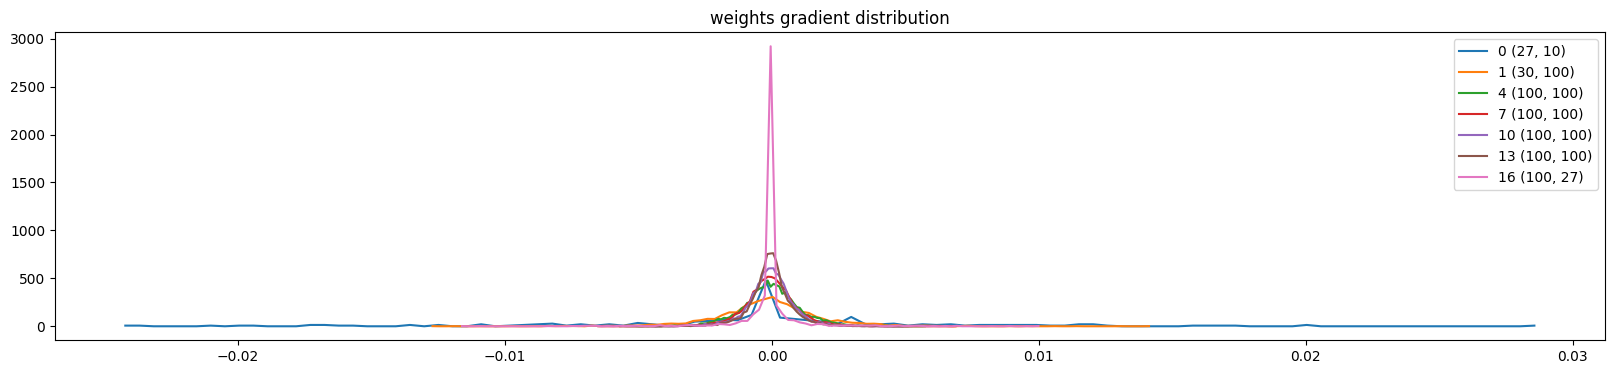

In [95]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

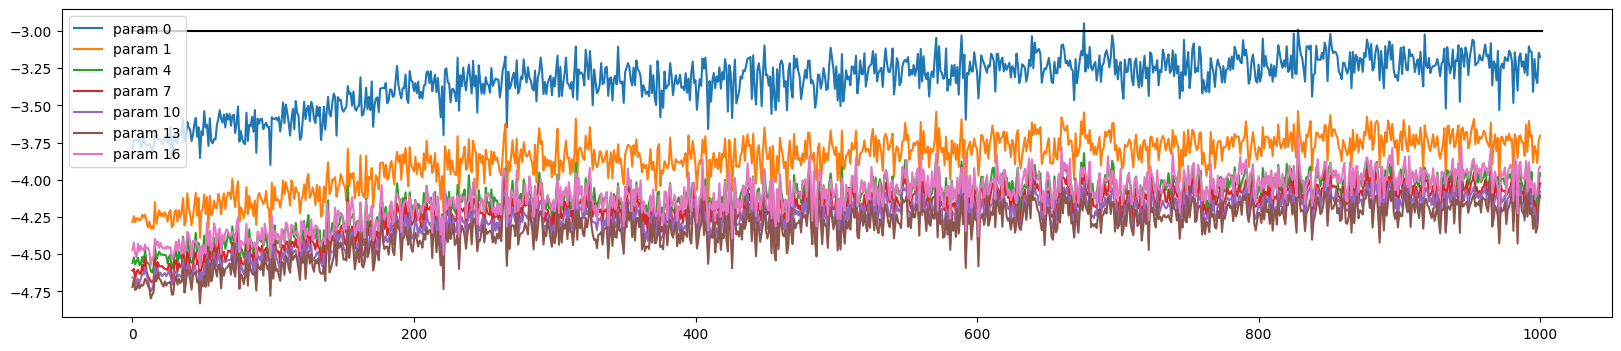

In [96]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);